In [370]:

import warnings
#warnings.filterwarnings('ignore')

import sys, os
import importlib.util 
sys.path.append(os.environ['TOOLS_PATH']) 
spec = importlib.util.spec_from_file_location("tradetestlib","C:\\Users\\JB\\Desktop\\Alpha\\Repositories\\Modules\\Generic\\TradeTestLib\\tradetestlib\\__init__.py")
tradetestlib = importlib.util.module_from_spec(spec)
sys.modules['tradetestlib'] = tradetestlib
spec.loader.exec_module(tradetestlib)
from sklearn.linear_model import LinearRegression 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime as dt, timedelta 

#import tradetestlib
from tqdm import tqdm
import MetaTrader5 as mt5
import tools
import btobject as bt 
import dbloader as db 

loader = db.DBLoader()

import statsmodels.api as sm  
from statsmodels.tsa.stattools import adfuller 



In [371]:
print(loader.query('PH_EQUITIES'))
backtest_start =dt(2014, 1, 1)
backtest_end = dt(2024, 1, 1)
train_end = dt(2022, 1, 1)
out_of_sample = dt(2024, 1, 1)
def load_close(ticker):
    return loader.load_data(ticker, resolution=loader.resolutions.RESOLUTION_D1, start_date=backtest_start, end_date=backtest_end)[['Close']]


['AC', 'ACEN', 'AEV', 'AGI', 'ALI', 'BDO', 'BLOOM', 'BPI', 'DMC', 'GLO', 'ICT', 'JFC', 'JGS', 'LTG', 'MBT', 'MER', 'NIKL', 'PGOLD', 'SCC', 'SM', 'SMC', 'SMPH', 'TEL', 'URC']


In [372]:
#ticker = 'BDO'
ticker = 'MER'
dataset = load_close(ticker)
dataset.columns = [ticker]
try:
    dataset[ticker] = dataset[ticker].str.replace(',','').astype('float') 
except:
    pass 
dataset.head()

,MER
Date,
2014-01-02,256.0
2014-01-03,254.2
2014-01-06,260.0
2014-01-07,257.0
2014-01-08,263.0


In [373]:


dataset['log_returns'] = dataset[ticker].pct_change()
dataset['mean'] = dataset[ticker].ewm(span=20).mean()
dataset['spread'] = dataset[ticker] - dataset['mean'] 

dataset['volatility'] = dataset[ticker].rolling(20).std()
dataset['rolling_vol'] = dataset['volatility'].rolling(20).max().rolling(90).mean()

dataset['spread_envelope_upper'] = dataset['spread'].rolling(20).max().ewm(span=20).mean()
dataset['spread_envelope_lower'] = dataset['spread'].rolling(20).min().ewm(span=20).mean()
spread_mean = dataset['spread'].ewm(span=10).mean()
spread_sdev = dataset['spread'].ewm(span=10).std()

dataset['z_score'] = (dataset['spread'] - spread_mean) / spread_sdev 
dataset['z_upper'] = 1
dataset['z_lower'] = -1



Text(0, 0.5, 'Close')

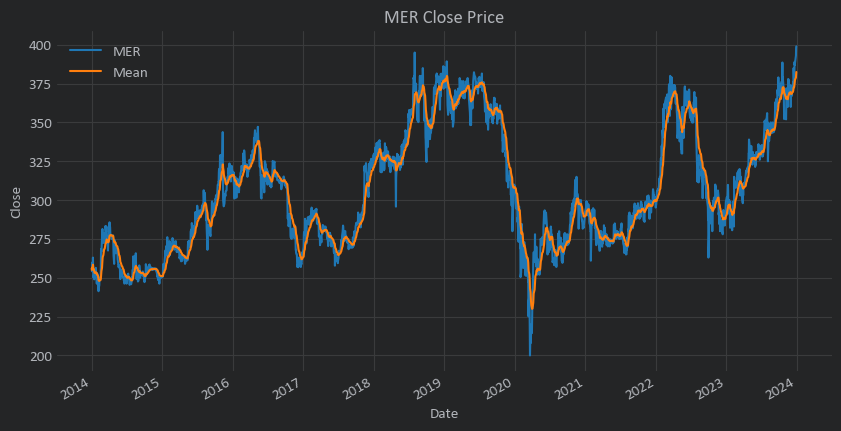

In [374]:
dataset[[ticker, 'mean']].plot(figsize=(10, 5))
plt.title(f'{ticker} Close Price')
plt.legend(labels=[ticker, 'Mean'])
plt.ylabel('Close')

<Axes: xlabel='Date'>

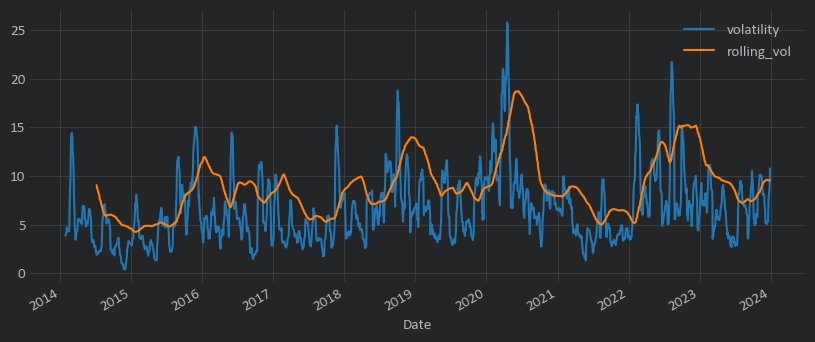

In [375]:
dataset[['volatility','rolling_vol']].plot(figsize=(10, 4))

Text(0.5, 1.0, 'Spread')

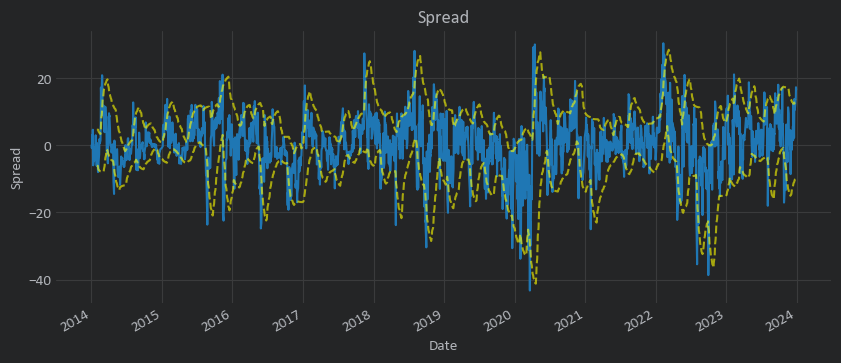

In [376]:
dataset['spread'].plot(figsize=(10, 4))
dataset['spread_envelope_upper'].plot(color='yellow', alpha = 0.6, ls='--')
dataset['spread_envelope_lower'].plot(color = 'yellow', alpha=0.6, ls = '--')
plt.ylabel('Spread')
plt.title('Spread')

Text(0.5, 1.0, 'Spread vs Z-Score')

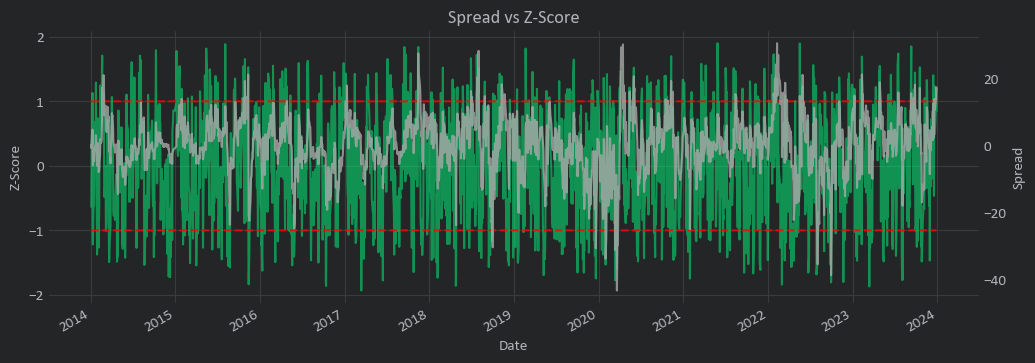

In [377]:
fig, ax = plt.subplots(figsize=(12, 4))
dataset['z_score'].plot(ax=ax, color = 'springgreen', alpha = 0.5)
dataset['z_upper'].plot(ax=ax, color = 'red', alpha=0.8, ls='--')
dataset['z_lower'].plot(ax=ax, color = 'red', alpha = 0.8, ls = '--')
plt.ylabel('Z-Score')

ax1=ax.twinx()
dataset['spread'].plot(ax=ax1,color='darkgrey', alpha = 0.8)
plt.ylabel('Spread')

plt.grid()
plt.title('Spread vs Z-Score')

In [378]:
# Test the spread for stationarity using ADF 
adf = adfuller(dataset['spread'], maxlag=1)
test_statistic, p_value, _, _, critical_value, _ = adf
print(f"ADF Result Parameters \n{adf}\n")

print(f"Test Statistic: {test_statistic:.4f}")

print(f"Critical Value: {critical_value['5%']:.4f}")

print(f"P-Value: {p_value:.4e}")

ADF Result Parameters 
(-13.21893170824513, 1.0110145617645106e-24, 1, 2435, {'1%': -3.4330383807110296, '5%': -2.8627276983827623, '10%': -2.5674022602026403}, 14268.324862182224)

Test Statistic: -13.2189
Critical Value: -2.8627
P-Value: 1.0110e-24


In [379]:
# Print Stationarity 
def is_stationary(p_value):
    if p_value < 0.05: 
        print(f"Series is Stationary. (p-value {p_value*100:.4f}%)")
    else:
        print(f"Series is NOT Stationary. (p-value {p_value*100:.4f}%)")
    return 
is_stationary(p_value)

Series is Stationary. (p-value 0.0000%)


In [380]:
## BUILD SIGNAL 

long_entry = (dataset['z_score'] < dataset['z_lower']) & (dataset['volatility'] < dataset['rolling_vol'])
long_exit = dataset['z_score'] >= 0 

short_entry = (dataset['z_score'] > dataset['z_upper']) & (dataset['volatility'] < dataset['rolling_vol'])
short_exit= dataset['z_score'] <= 0 

dataset['long_pos'] = np.nan 
dataset.loc[long_entry, 'long_pos'] = 1
dataset.loc[long_exit, 'long_pos'] = 0 
dataset['long_pos'] = dataset['long_pos'].ffill() 

dataset['short_pos'] = np.nan 
dataset.loc[short_entry, 'short_pos'] = -1
dataset.loc[short_exit, 'short_pos'] = 0 
dataset['short_pos'] = dataset['short_pos'].ffill()

dataset = dataset.fillna(0)

dataset['signal'] = dataset['long_pos'] + dataset['short_pos']

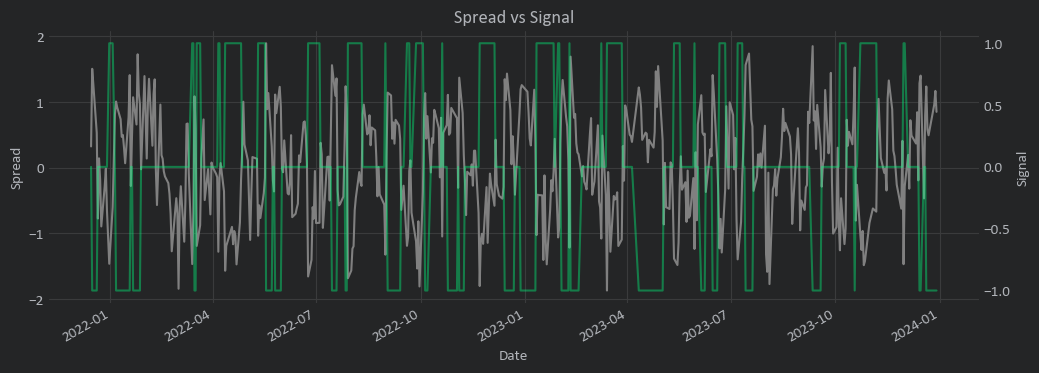

In [381]:
fig, ax = plt.subplots(figsize=(12, 4))
dataset['z_score'].tail(500).plot(color='grey')
plt.ylabel('Spread')

ax1=ax.twinx()
dataset['signal'].tail(500).plot(color = 'springgreen', alpha=0.4)
plt.ylabel('Signal')

plt.title('Spread vs Signal')
plt.grid()

In [382]:
dataset['strategy'] = dataset['signal'].shift(1) * dataset['log_returns'] # shift to mitigate look ahead bias

# Long Only - Mute Short Positions
dataset.loc[dataset['signal'] == -1, 'strategy'] = 0
deposit = 1000000

equity = (dataset['strategy']+1).cumprod()*deposit
peak = equity.cummax()
drawdown = (equity-peak) / peak * 100 

Text(0, 0.5, 'Drawdown (%)')

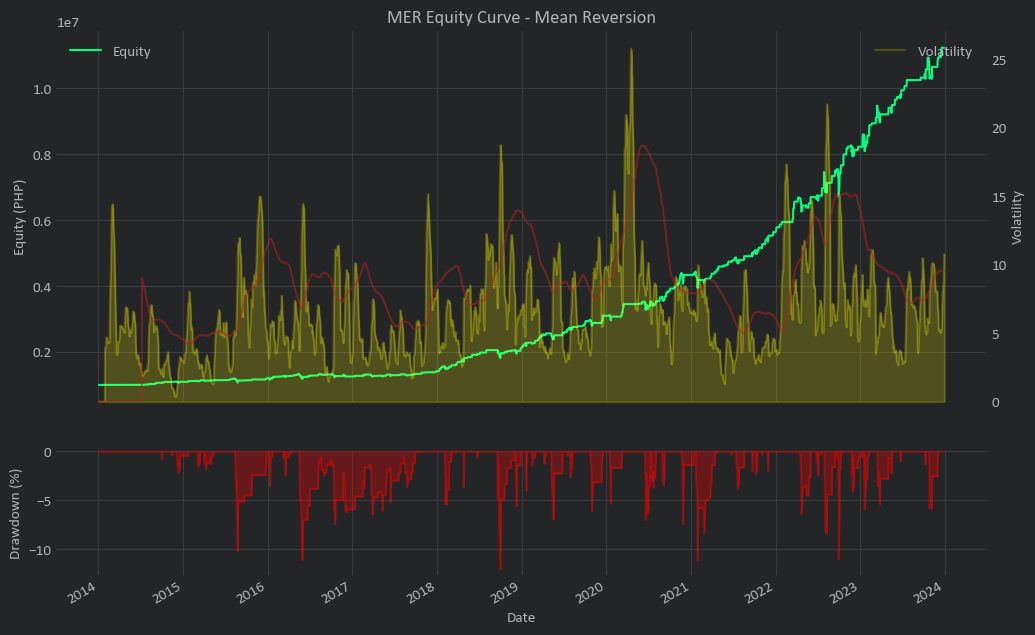

In [383]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True,gridspec_kw={'height_ratios':[3, 1]})
equity.plot(color='springgreen', ax = ax)
ax.set_ylabel('Equity (PHP)')
ax.legend(labels=['Equity'])

ax1=ax.twinx()
dataset['volatility'].plot(ax=ax1, kind='area',color='yellow',alpha=0.2)
dataset['rolling_vol'].plot(ax=ax1, color='firebrick',alpha=0.5)
plt.grid()
ax1.legend(labels=['Volatility'])
ax1.set_ylabel('Volatility')
plt.title(f'{ticker} Equity Curve - Mean Reversion')

drawdown.plot(ax=ax2, kind='area', color = 'red', alpha = 0.3)
ax2.set_ylabel('Drawdown (%)')

In [386]:


traded = dataset.query('strategy != 0')
strategy_mean = traded['strategy'].mean()
strategy_std = traded['strategy'].std()
# Sharpe Ratio 
risk_free_rate = 0.05 # Assume 5.0% per year 

# Daily Sharpe Ratio 
# Note: We convert risk-free rate to daily rate, divide by 252 
sharpe_daily = (strategy_mean - (risk_free_rate/252)) / strategy_std 
# Annualized Sharpe Ratio 
sharpe_annual = sharpe_daily * np.sqrt(252)
print(f"Annualized Sharpe Ratio: {sharpe_annual:.4f}")

Annualized Sharpe Ratio: 3.7120


Average Annual Returns: 25.16% RoMaD: 2.09


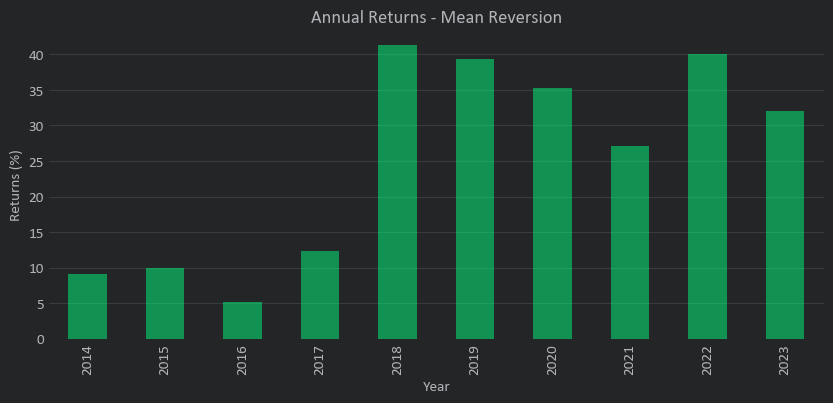

In [385]:

target_data = dataset['strategy']
grouped = target_data.groupby(target_data.index.year).sum() * 100

annual_mean = grouped.mean()
romad = abs(annual_mean / drawdown.min())

print(f"Average Annual Returns: {annual_mean:.2f}% RoMaD: {romad:.2f}")
grouped.plot(kind='bar', figsize=(10, 4), color='springgreen', alpha = 0.5)
plt.xlabel('Year')
plt.ylabel('Returns (%)')
plt.title("Annual Returns - Mean Reversion")
plt.grid(axis='x')
